# Imports

In [1]:
import keras
from keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# HyperParameters

In [2]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 3

# Load the CIFAR-10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


# Prepare tf.data.Dataset objects

In [4]:
image_size = 32
auto = tf.data.AUTOTUNE

augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size),
    keras.layers.RandomFlip("horizontal"),
]


def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

# ConvMixer utilities

In [5]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

In [6]:
def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

In [7]:

def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x

In [8]:
def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Model training and evaluation utility

In [13]:

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "./tmp/checkpoin.tf"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

# Train and evaluate model

In [14]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/3
352/352 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 0.5618INFO:tensorflow:Assets written to: ./tmp\checkpoin.tf\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoin.tf\assets


352/352 [==============================] - 2624s 7s/step - loss: 1.2253 - accuracy: 0.5618 - val_loss: 3.8823 - val_accuracy: 0.1158
Epoch 2/3
352/352 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.7271INFO:tensorflow:Assets written to: ./tmp\checkpoin.tf\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoin.tf\assets


352/352 [==============================] - 2236s 6s/step - loss: 0.7769 - accuracy: 0.7271 - val_loss: 0.7445 - val_accuracy: 0.7346
Epoch 3/3
79/79 [==============================] - 119s 2s/step - loss: 0.7637 - accuracy: 0.7362
Test accuracy: 73.62%


# Visualizing the internals of ConvMixer

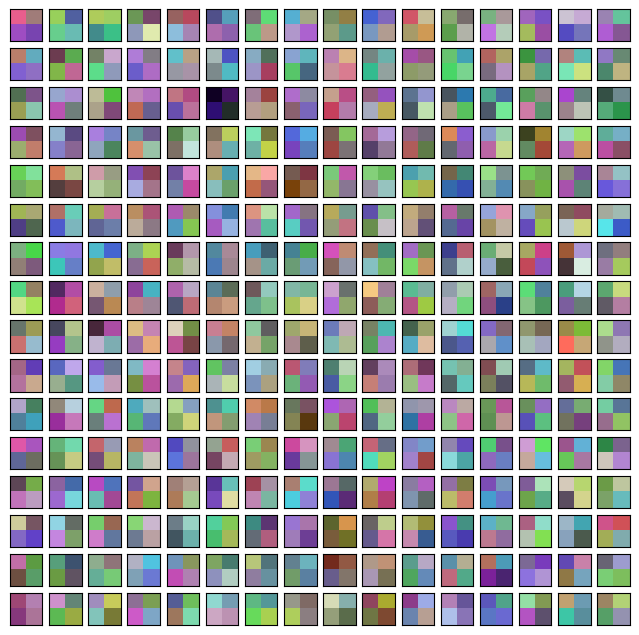

In [15]:
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

5 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x000002580B672B00>
12 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025809D2F8B0>
19 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025810F6DFC0>
26 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025810F77280>
33 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025810F8D600>
40 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025810FA0D90>
47 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025810FA2620>
54 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000025810FCB6D0>


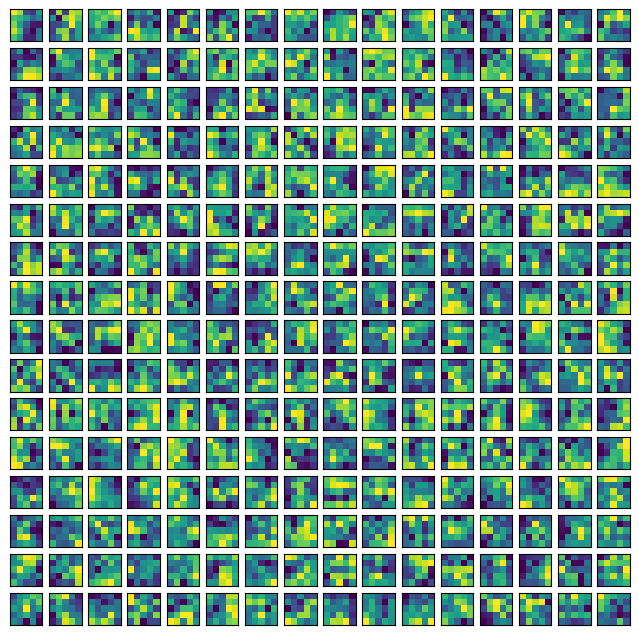

In [16]:
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)